## Data Preperation

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#  Load the dataset
file_path = "D:\Coding\Energy-Management_Project\data\data_15min.csv"
df = pd.read_csv(file_path)

In [3]:
print("Initial shape:", df.shape)
print(df.dtypes)
print(df.isnull().sum().head())  # Show top missing values

Initial shape: (153810, 71)
utc_timestamp                          object
cet_cest_timestamp                     object
DE_KN_industrial1_grid_import         float64
DE_KN_industrial1_pv_1                float64
DE_KN_industrial1_pv_2                float64
                                       ...   
DE_KN_residential6_grid_export        float64
DE_KN_residential6_grid_import        float64
DE_KN_residential6_pv                 float64
DE_KN_residential6_washing_machine    float64
Unnamed: 70                            object
Length: 71, dtype: object
utc_timestamp                        0
cet_cest_timestamp                   0
DE_KN_industrial1_grid_import    88080
DE_KN_industrial1_pv_1           84659
DE_KN_industrial1_pv_2           84659
dtype: int64


In [4]:
# Convert timestamp to datetime and set index
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'], utc=True, errors='coerce')
df.set_index('utc_timestamp', inplace=True)

In [5]:
df.columns

Index(['cet_cest_timestamp', 'DE_KN_industrial1_grid_import',
       'DE_KN_industrial1_pv_1', 'DE_KN_industrial1_pv_2',
       'DE_KN_industrial2_grid_import', 'DE_KN_industrial2_pv',
       'DE_KN_industrial2_storage_charge',
       'DE_KN_industrial2_storage_decharge', 'DE_KN_industrial3_area_offices',
       'DE_KN_industrial3_area_room_1', 'DE_KN_industrial3_area_room_2',
       'DE_KN_industrial3_area_room_3', 'DE_KN_industrial3_area_room_4',
       'DE_KN_industrial3_compressor', 'DE_KN_industrial3_cooling_aggregate',
       'DE_KN_industrial3_cooling_pumps', 'DE_KN_industrial3_dishwasher',
       'DE_KN_industrial3_ev', 'DE_KN_industrial3_grid_import',
       'DE_KN_industrial3_machine_1', 'DE_KN_industrial3_machine_2',
       'DE_KN_industrial3_machine_3', 'DE_KN_industrial3_machine_4',
       'DE_KN_industrial3_machine_5', 'DE_KN_industrial3_pv_facade',
       'DE_KN_industrial3_pv_roof', 'DE_KN_industrial3_refrigerator',
       'DE_KN_industrial3_ventilation', 'DE_KN_public1

In [6]:
# Filter only the required column

target_col = 'DE_KN_residential5_grid_import'
df = df[[target_col]].copy()

In [7]:
# Rename target column
df.rename(columns={target_col: 'r5_gi'}, inplace=True)

In [8]:
# Drop missing value
df.dropna(inplace=True)

In [9]:
# check
print("Data after cleaning:")
print(df.head())
print("Data range:", df.index.min(), "to", df.index.max())
print("Data frequency check (first 5 diffs):\n", df.index.to_series().diff().head())

Data after cleaning:
                           r5_gi
utc_timestamp                   
2015-10-26 11:30:00+00:00  0.020
2015-10-26 11:45:00+00:00  0.045
2015-10-26 12:00:00+00:00  0.075
2015-10-26 12:15:00+00:00  0.130
2015-10-26 12:30:00+00:00  0.185
Data range: 2015-10-26 11:30:00+00:00 to 2019-05-01 22:00:00+00:00
Data frequency check (first 5 diffs):
 utc_timestamp
2015-10-26 11:30:00+00:00               NaT
2015-10-26 11:45:00+00:00   0 days 00:15:00
2015-10-26 12:00:00+00:00   0 days 00:15:00
2015-10-26 12:15:00+00:00   0 days 00:15:00
2015-10-26 12:30:00+00:00   0 days 00:15:00
Name: utc_timestamp, dtype: timedelta64[ns]


### Convert cumulative data into actual per-interval usage

In [10]:
# Convert cumulative to actual usage
df['r5_gi'] = df['r5_gi'].diff()

# Drop the first row which becomes NaN after diff
df.dropna(inplace=True)

In [11]:
# Optional sanity check for negative values
print("Negative values count:", (df['r5_gi'] < 0).sum())


df = df[df['r5_gi'] >= 0]  # or df['r5_gi'] = df['r5_gi'].clip(lower=0)

Negative values count: 0


## Data Viz

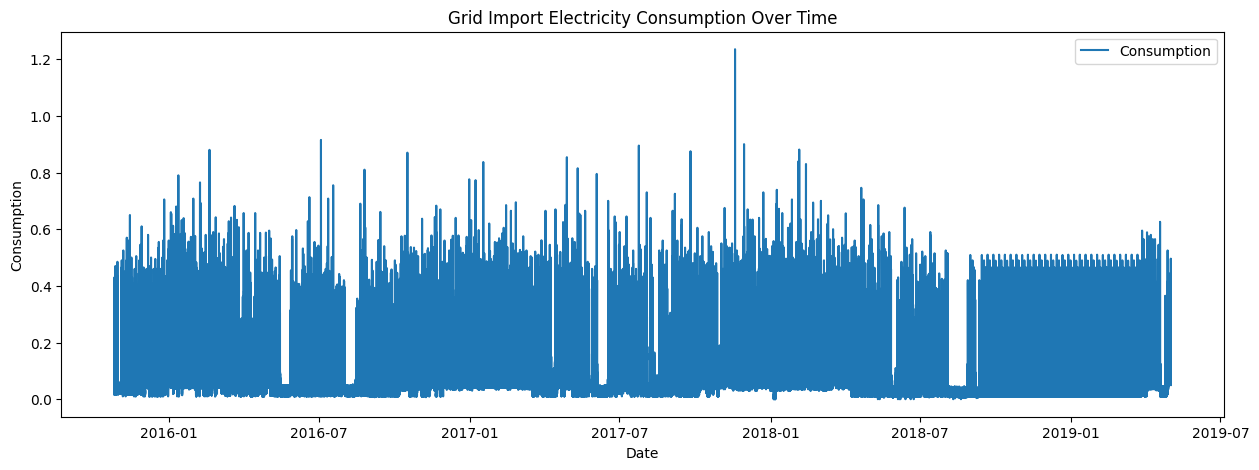

In [13]:
#Plot the time series consumption
plt.figure(figsize=(15,5))
plt.plot(df.index, df['r5_gi'], label='Consumption')
plt.title('Grid Import Electricity Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.legend()
plt.show()

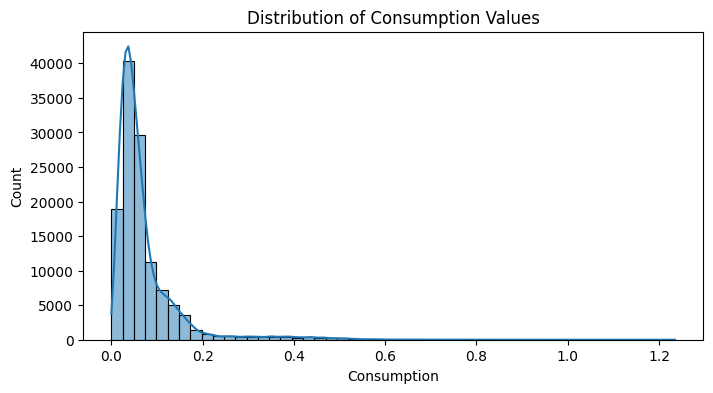

In [14]:
# Distribution plot of consumption
plt.figure(figsize=(8,4))
sns.histplot(df['r5_gi'], bins=50, kde=True)
plt.title('Distribution of Consumption Values')
plt.xlabel('Consumption')
plt.show()

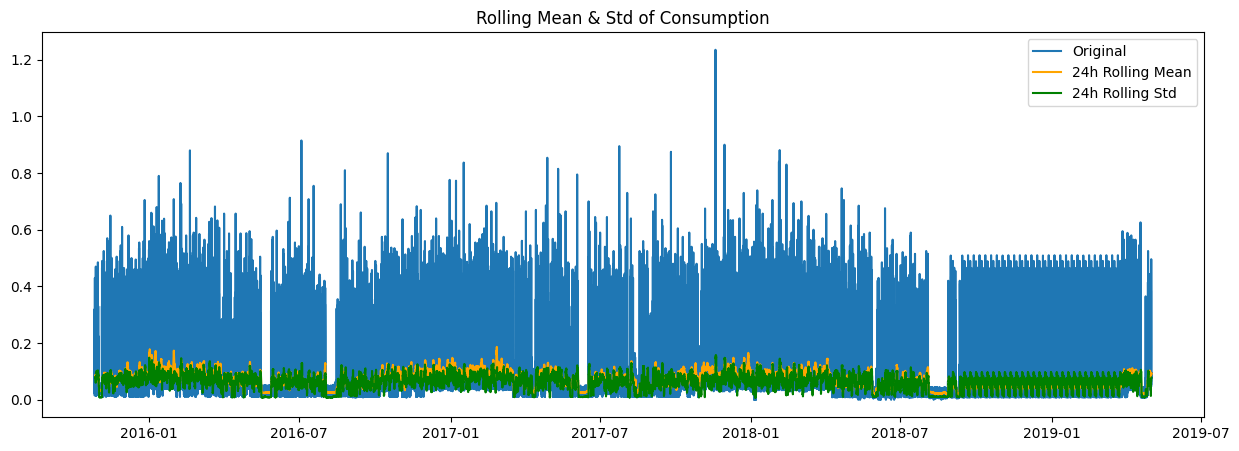

In [15]:
# Rolling mean and rolling std to check trend and seasonality

rolling_window = 96  # 96 * 15min = 24 hours
plt.figure(figsize=(15,5))
plt.plot(df['r5_gi'], label='Original')
plt.plot(df['r5_gi'].rolling(window=rolling_window).mean(), label='24h Rolling Mean', color='orange')
plt.plot(df['r5_gi'].rolling(window=rolling_window).std(), label='24h Rolling Std', color='green') 
plt.title('Rolling Mean & Std of Consumption')
plt.legend()
plt.show()

## Time-Series Viz

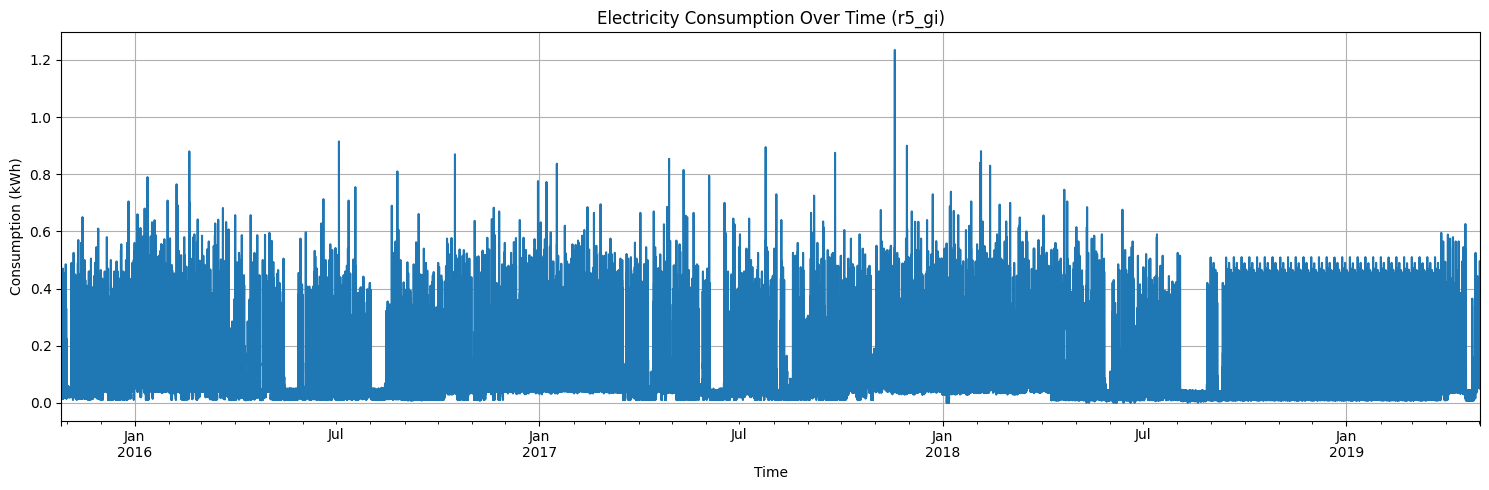

In [16]:
plt.figure(figsize=(15,5))
df['r5_gi'].plot()
plt.title("Electricity Consumption Over Time (r5_gi)")
plt.ylabel("Consumption (kWh)")
plt.xlabel("Time")
plt.grid(True)
plt.tight_layout()
plt.show()

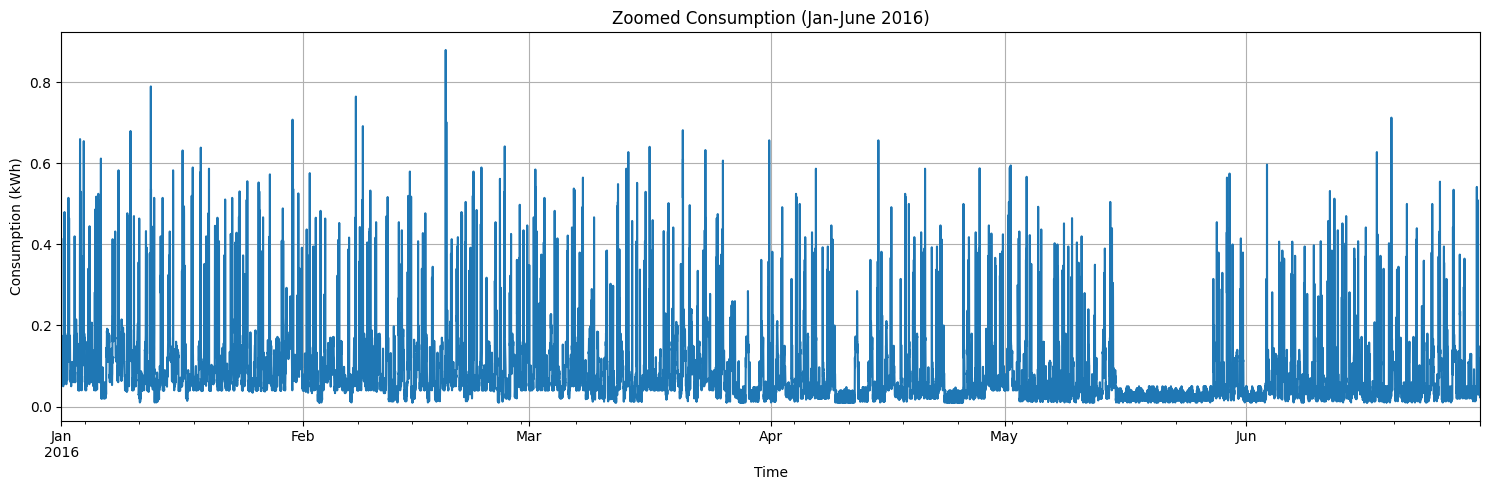

In [17]:
df_zoom = df['2016-01-01':'2016-06-30']
plt.figure(figsize=(15,5))
df_zoom['r5_gi'].plot()
plt.title("Zoomed Consumption (Jan-June 2016)")
plt.ylabel("Consumption (kWh)")
plt.xlabel("Time")
plt.grid(True)
plt.tight_layout()
plt.show()


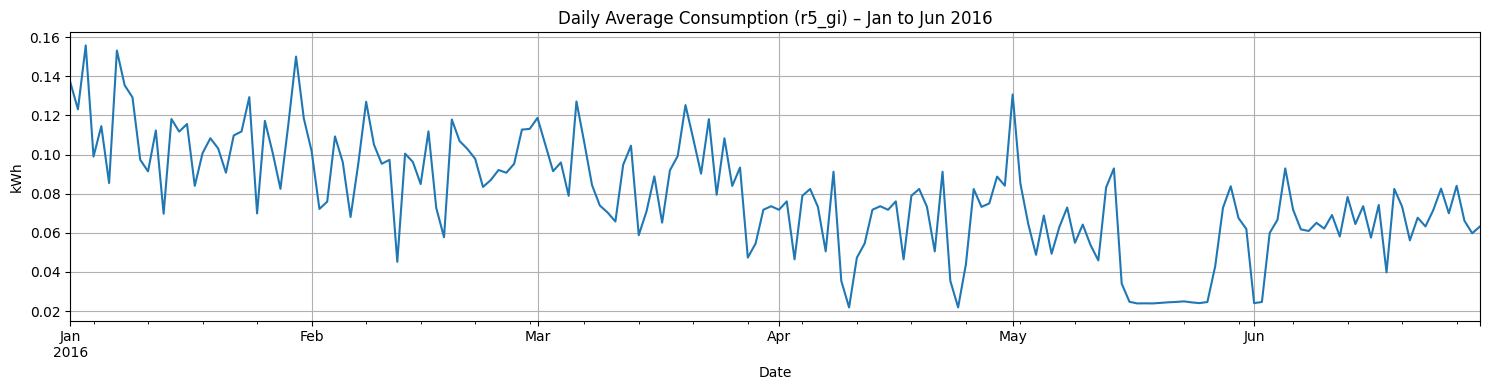

In [18]:
# Resample to daily average consumption
df_daily = df['r5_gi'].resample('D').mean()

# Filter for Jan to Jun 2016
df_daily_subset = df_daily.loc['2016-01-01':'2016-06-30']

# Plot
plt.figure(figsize=(15,4))
df_daily_subset.plot()
plt.title("Daily Average Consumption (r5_gi) – Jan to Jun 2016")
plt.ylabel("kWh")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

## Adding ON/OFF Column

In [19]:
# Create ON/OFF column: 1 if heat pump was ON, 0 if OFF
# It works fine, but:It might be too sensitive to noise (e.g., 0.001 kWh is not meaningful). Might misclassify short spikes or drops in cumulative readings.
# so chose to consider 0.01 as threshold instead of 0

threshold = 0.04
df['r5_gi_onoff'] = (df['r5_gi'] > threshold).astype(int)

In [20]:
# Check result
print(df[['r5_gi', 'r5_gi_onoff']].head(20))
print("\nValue counts:")
print(df['r5_gi_onoff'].value_counts())

                           r5_gi  r5_gi_onoff
utc_timestamp                                
2015-10-26 11:45:00+00:00  0.025            0
2015-10-26 12:00:00+00:00  0.030            0
2015-10-26 12:15:00+00:00  0.055            1
2015-10-26 12:30:00+00:00  0.055            1
2015-10-26 12:45:00+00:00  0.210            1
2015-10-26 13:00:00+00:00  0.320            1
2015-10-26 13:15:00+00:00  0.050            1
2015-10-26 13:30:00+00:00  0.050            1
2015-10-26 13:45:00+00:00  0.050            1
2015-10-26 14:00:00+00:00  0.060            1
2015-10-26 14:15:00+00:00  0.060            1
2015-10-26 14:30:00+00:00  0.050            1
2015-10-26 14:45:00+00:00  0.050            1
2015-10-26 15:00:00+00:00  0.060            1
2015-10-26 15:15:00+00:00  0.060            1
2015-10-26 15:30:00+00:00  0.080            1
2015-10-26 15:45:00+00:00  0.040            1
2015-10-26 16:00:00+00:00  0.020            0
2015-10-26 16:15:00+00:00  0.015            0
2015-10-26 16:30:00+00:00  0.035  

In [21]:
# Count total ON and OFF states
on_off_counts = df['r5_gi_onoff'].value_counts().rename(index={0: 'OFF', 1: 'ON'})

print("Heat Pump ON/OFF Summary:")
print(on_off_counts)


Heat Pump ON/OFF Summary:
r5_gi_onoff
ON     72389
OFF    50821
Name: count, dtype: int64


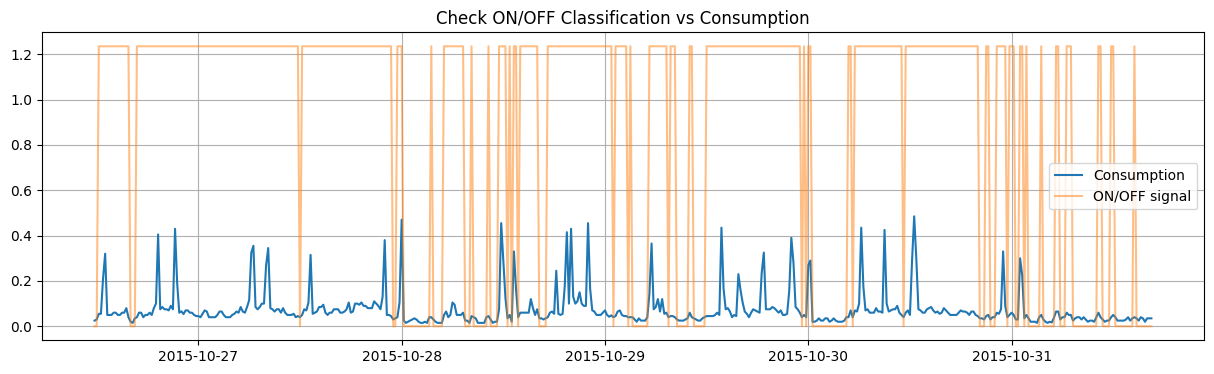

In [22]:
# ON/OFF Plot

plt.figure(figsize=(15,4))
plt.plot(df.index[:500], df['r5_gi'][:500], label="Consumption")
plt.plot(df.index[:500], df['r5_gi_onoff'][:500]*df['r5_gi'].max(), label="ON/OFF signal", alpha=0.5)
plt.legend()
plt.title("Check ON/OFF Classification vs Consumption")
plt.grid(True)
plt.show()


In [24]:
# Check the distribution of r5_gi when ON

print(df[df['r5_gi_onoff'] == 1]['r5_gi'].describe())
print("\nVery low ON readings (< 0.04 kWh):", (df['r5_gi'] < threshold).sum())

count    72389.000000
mean         0.102170
std          0.086022
min          0.040000
25%          0.055000
50%          0.070000
75%          0.115000
max          1.235000
Name: r5_gi, dtype: float64

Very low ON readings (< 0.04 kWh): 50821


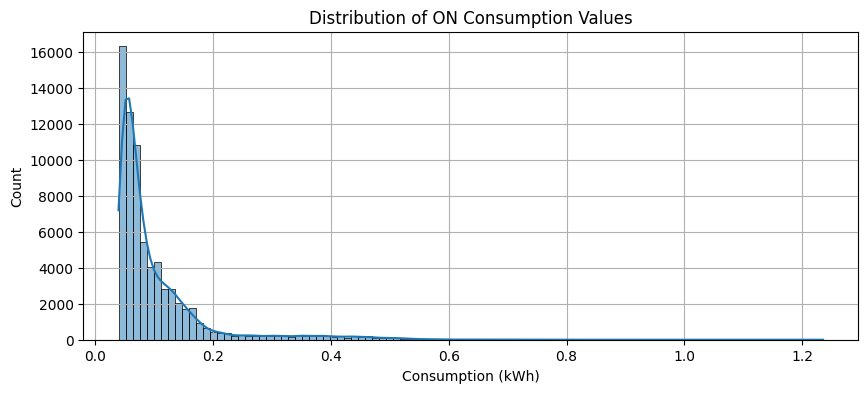

In [25]:
# Plot histogram of ON consumption

import seaborn as sns
plt.figure(figsize=(10,4))
sns.histplot(df[df['r5_gi_onoff'] == 1]['r5_gi'], bins=100, kde=True)
plt.title("Distribution of ON Consumption Values")
plt.xlabel("Consumption (kWh)")
plt.grid(True)
plt.show()

## Feature Creation(Date time feautures)

In [26]:
# time-based features from your datetime index to help the model learn patterns related to when the appliance tends to be ON or OFF.

df_feat = df.copy()
df_feat['hour'] = df_feat.index.hour
df_feat['dayofweek'] = df_feat.index.dayofweek
df_feat['quarter'] = df_feat.index.quarter
df_feat['month'] = df_feat.index.month
df_feat['year'] = df_feat.index.year
df_feat['dayofyear'] = df_feat.index.dayofyear
df_feat['dayofmonth'] = df_feat.index.day
df_feat['weekofyear'] = df_feat.index.isocalendar().week.astype(int)


In [27]:
# Check the new dataframe structure and sample values
print(df_feat.head())

                           r5_gi  r5_gi_onoff  hour  dayofweek  quarter  \
utc_timestamp                                                             
2015-10-26 11:45:00+00:00  0.025            0    11          0        4   
2015-10-26 12:00:00+00:00  0.030            0    12          0        4   
2015-10-26 12:15:00+00:00  0.055            1    12          0        4   
2015-10-26 12:30:00+00:00  0.055            1    12          0        4   
2015-10-26 12:45:00+00:00  0.210            1    12          0        4   

                           month  year  dayofyear  dayofmonth  weekofyear  
utc_timestamp                                                              
2015-10-26 11:45:00+00:00     10  2015        299          26          44  
2015-10-26 12:00:00+00:00     10  2015        299          26          44  
2015-10-26 12:15:00+00:00     10  2015        299          26          44  
2015-10-26 12:30:00+00:00     10  2015        299          26          44  
2015-10-26 12:45:0

## Visualize Feature-Target Relationship (for ON data only)

In [28]:
# Filter ON rows only, to analyze when and how much energy is Used

df_on = df[df['r5_gi_onoff'] == 1].copy()

In [29]:
# Create time features for df_on

df_on['hour'] = df_on.index.hour  # extract the Hours(0 to 23)
df_on['dayofweek'] = df_on.index.dayofweek  # extract the day of week (0= Monday to 6 = Sunday)

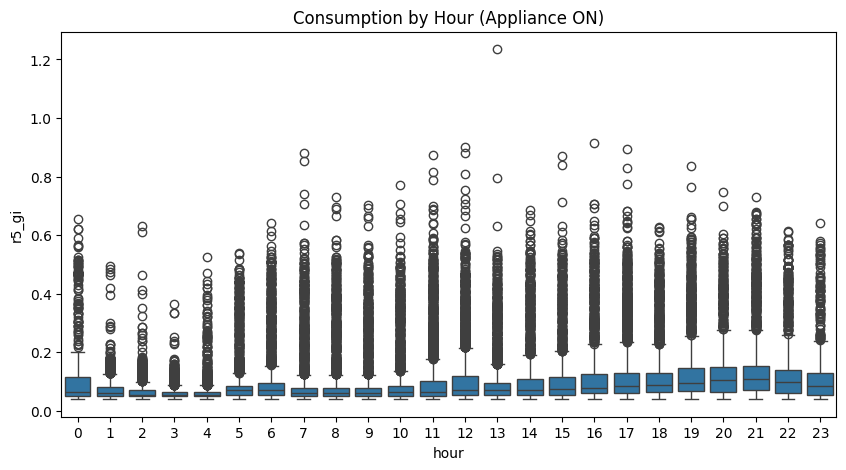

In [30]:
# distribution of consumption during each hour of the day

plt.figure(figsize=(10,5))
sns.boxplot(x='hour', y='r5_gi', data=df_on)
plt.title('Consumption by Hour (Appliance ON)')
plt.show()

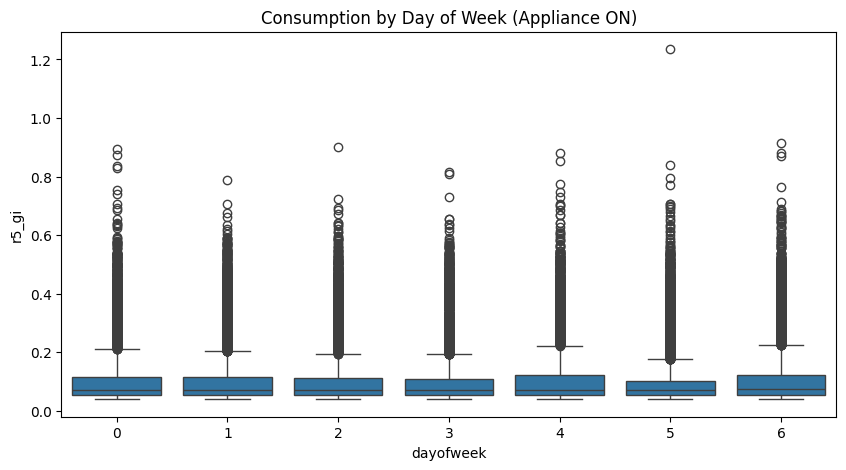

In [31]:
plt.figure(figsize=(10,5))
sns.boxplot(x='dayofweek', y='r5_gi', data=df_on)
plt.title('Consumption by Day of Week (Appliance ON)')
plt.show()

In [32]:
# Group-wise statistics (mean, median, std) of consumption by hour


df_on.groupby('hour')['r5_gi'].agg(['mean', 'median', 'std', 'count'])

,mean,median,std,count
hour,,,,
0,0.096877,0.066,0.083383,2310
1,0.073177,0.060,0.040662,2026
2,0.067338,0.055,0.038823,1914
3,0.061606,0.055,0.025168,1741
4,0.064529,0.055,0.042258,2183
5,0.089699,0.070,0.076303,3283
6,0.099426,0.070,0.089319,2914
7,0.088750,0.062,0.083691,3001
8,0.088948,0.060,0.085648,2908


In [33]:
# Summary statistics of consumption by day of week

df_on.groupby('dayofweek')['r5_gi'].describe()

,count,mean,std,min,25%,50%,75%,max
dayofweek,,,,,,,,
0,10456.0,0.102404,0.086291,0.04,0.054,0.070,0.117,0.895
1,10778.0,0.102192,0.083236,0.04,0.055,0.072,0.115,0.790
2,10606.0,0.099890,0.083315,0.04,0.055,0.070,0.111,0.900
3,9844.0,0.096406,0.078451,0.04,0.054,0.070,0.110,0.815
4,10323.0,0.106497,0.089337,0.04,0.055,0.073,0.122,0.880
5,10170.0,0.097836,0.084091,0.04,0.054,0.070,0.103,1.235
6,10212.0,0.109775,0.095590,0.04,0.055,0.075,0.123,0.915


In [34]:
# Count how many times the heat pump is ON in each hour (ON frequency)

df['r5_gi_onoff'].groupby(df.index.hour).sum()

utc_timestamp
0     2310
1     2026
2     1914
3     1741
4     2183
5     3283
6     2914
7     3001
8     2908
9     2755
10    2845
11    3087
12    3121
13    3275
14    3251
15    3070
16    3293
17    3539
18    3825
19    4246
20    4134
21    3694
22    3286
23    2688
Name: r5_gi_onoff, dtype: int64

## Train Test Split (time order series)

In [35]:
# Define the exact time range for training and testing

train_start = pd.Timestamp("2016-01-01 00:00:00+00:00")
train_end = pd.Timestamp("2016-06-30 23:45:00+00:00")
test_start = pd.Timestamp("2016-07-01 00:00:00+00:00")
test_end = pd.Timestamp("2016-07-07 23:45:00+00:00")

In [36]:
# Create boolean masks that are True when the row timestamp falls within train/test periods
# These masks ensure only rows within the date range are selected.

train_mask = (df_feat.index >= train_start) & (df_feat.index <= train_end)
test_mask = (df_feat.index >= test_start) & (df_feat.index <= test_end)

In [37]:
# Select features and target columns

feature_cols = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']
target_col = 'r5_gi_onoff'

In [38]:
# Split the feature matrix and target vector for train and test

X_train = df_feat.loc[train_mask, feature_cols].copy()
y_train = df_feat.loc[train_mask, 'r5_gi_onoff']

X_test = df_feat.loc[test_mask, feature_cols].copy()
y_test = df_feat.loc[test_mask, 'r5_gi_onoff']

In [39]:
# Print shapes and summary counts to verify

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train ON count: {y_train.sum()}, Test ON count: {y_test.sum()}")

Train shape: (17472, 8), Test shape: (672, 8)
Train ON count: 10797, Test ON count: 342


In [40]:
# Create lag and rolling features on X_train and X_test

def create_time_features(df):
    df['lag_1'] = df['r5_gi'].shift(1)
    df['lag_2'] = df['r5_gi'].shift(2)
    df['rolling_mean_4'] = df['r5_gi'].rolling(window=4).mean()
    df['rolling_mean_12'] = df['r5_gi'].rolling(window=12).mean()
    df['rolling_std_4'] = df['r5_gi'].rolling(window=4).std()
    df['rolling_std_12'] = df['r5_gi'].rolling(window=12).std()
    df.fillna(0, inplace=True)
    return df

In [41]:
# Add these features to original dataframe first (only for rows in train/test periods)

df_feat['lag_1'] = df_feat['r5_gi'].shift(1).fillna(0)
df_feat['lag_2'] = df_feat['r5_gi'].shift(2).fillna(0)
df_feat['rolling_mean_4'] = df_feat['r5_gi'].rolling(window=4).mean().fillna(0)
df_feat['rolling_mean_12'] = df_feat['r5_gi'].rolling(window=12).mean().fillna(0)
df_feat['rolling_std_4'] = df_feat['r5_gi'].rolling(window=4).std().fillna(0)
df_feat['rolling_std_12'] = df_feat['r5_gi'].rolling(window=12).std().fillna(0)


In [42]:
# Update feature columns list with new features

extended_features = feature_cols + ['lag_1', 'lag_2', 'rolling_mean_4', 'rolling_mean_12', 'rolling_std_4', 'rolling_std_12']

In [43]:
# Prepare final train/test feature sets

X_train = df_feat.loc[train_mask, extended_features]
X_test = df_feat.loc[test_mask, extended_features]

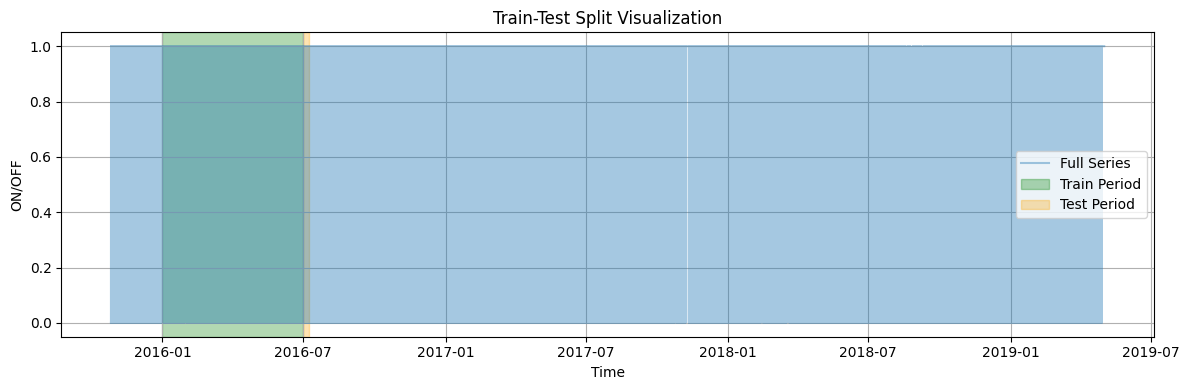

In [44]:
# viz portion of data for training and testing

plt.figure(figsize=(12,4))
plt.plot(df_feat.index, df_feat['r5_gi_onoff'], label='Full Series', alpha=0.4)
plt.axvspan(train_start, train_end, color='green', alpha=0.3, label='Train Period')
plt.axvspan(test_start, test_end, color='orange', alpha=0.3, label='Test Period')
plt.title("Train-Test Split Visualization")
plt.xlabel("Time")
plt.ylabel("ON/OFF")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


In [45]:
print("Train class distribution:")
print(y_train.value_counts(normalize=True).round(3))

print("\nTest class distribution:")
print(y_test.value_counts(normalize=True).round(3))


Train class distribution:
r5_gi_onoff
1    0.618
0    0.382
Name: proportion, dtype: float64

Test class distribution:
r5_gi_onoff
1    0.509
0    0.491
Name: proportion, dtype: float64


## Train-Test Split for ON/OFF Model

In [46]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [47]:
# Calculate class imbalance weight

neg, pos = y_train.value_counts()
scale_pos_weight = neg / pos

print(f"Scale_pos_weight: {scale_pos_weight:.2f}")

Scale_pos_weight: 1.62


In [48]:
# Initialize the classifier with class balancing

model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

In [49]:
# Train the model normally

model.fit(X_train, y_train)

d:\Coding\Energy_Management\em\lib\site-packages\xgboost\training.py:183: UserWarning: [12:38:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [50]:
# predict ON/OFF TEST

y_pred = model.predict(X_test)

In [51]:
# evaluate model performance

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8883928571428571
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.86      0.88       330
           1       0.87      0.92      0.89       342

    accuracy                           0.89       672
   macro avg       0.89      0.89      0.89       672
weighted avg       0.89      0.89      0.89       672

Confusion Matrix:
 [[284  46]
 [ 29 313]]


####

Accuracy: 88.84% — Strong overall

Precision (0.91) for OFF means: 91% of OFF predictions were actually OFF.

Recall (0.92) for ON means: the model detected 92% of all true ON instances.

## Regression model (predict consumption when ON)

In [52]:
# Filter data where heat pump is ON (consumption > 0)

df_reg = df[df['r5_gi_onoff'] == 1].copy()

In [53]:
# Create time-based features again for this subset

df_reg['hour'] = df_reg.index.hour
df_reg['dayofweek'] = df_reg.index.dayofweek
df_reg['quarter'] = df_reg.index.quarter
df_reg['month'] = df_reg.index.month
df_reg['year'] = df_reg.index.year
df_reg['dayofyear'] = df_reg.index.dayofyear
df_reg['dayofmonth'] = df_reg.index.day
df_reg['weekofyear'] = df_reg.index.isocalendar().week.astype(int)

In [54]:
# Define features and target for regression

feature_cols_reg = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']
target_col_reg = 'r5_gi'  # Actual consumption values

In [55]:
# Define train/test date ranges (keep consistent with ON/OFF model)
train_mask_reg = (df_reg.index >= train_start) & (df_reg.index <= train_end)
test_mask_reg = (df_reg.index >= test_start) & (df_reg.index <= test_end)

X_train_reg = df_reg.loc[train_mask_reg, feature_cols_reg]
y_train_reg = df_reg.loc[train_mask_reg, target_col_reg]

X_test_reg = df_reg.loc[test_mask_reg, feature_cols_reg]
y_test_reg = df_reg.loc[test_mask_reg, target_col_reg]

In [56]:
# Check shapes

print(f"Regression train shape: {X_train_reg.shape}, test shape: {X_test_reg.shape}")
print(f"Regression train target mean: {y_train_reg.mean():.4f}, test target mean: {y_test_reg.mean():.4f}")

Regression train shape: (10797, 8), test shape: (342, 8)
Regression train target mean: 0.1115, test target mean: 0.1053


## Train and Evaluate the Regression Model

In [57]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [58]:
# Initialize the XGBoost Regressor

reg_model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)

In [59]:
# Train the model

reg_model.fit(X_train_reg, y_train_reg)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [60]:
# Predict on test data

y_pred_reg = reg_model.predict(X_test_reg)

In [61]:
# Evaluate

mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)  # manually compute RMSE
mae = mean_absolute_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

In [62]:
print(f"Regression Model Evaluation:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Regression Model Evaluation:
RMSE: 0.0986
MAE: 0.0602
R² Score: -0.0391


## Predicting

In [63]:
# Predict on test set

y_test_pred = reg_model.predict(X_test_reg)

In [64]:
# Create DataFrame to hold actual and predicted values with timestamps as index

df_test_compare = pd.DataFrame({
    'Actual Consumption': y_test_reg,
    'Predicted Consumption': y_test_pred
}, index=X_test_reg.index)

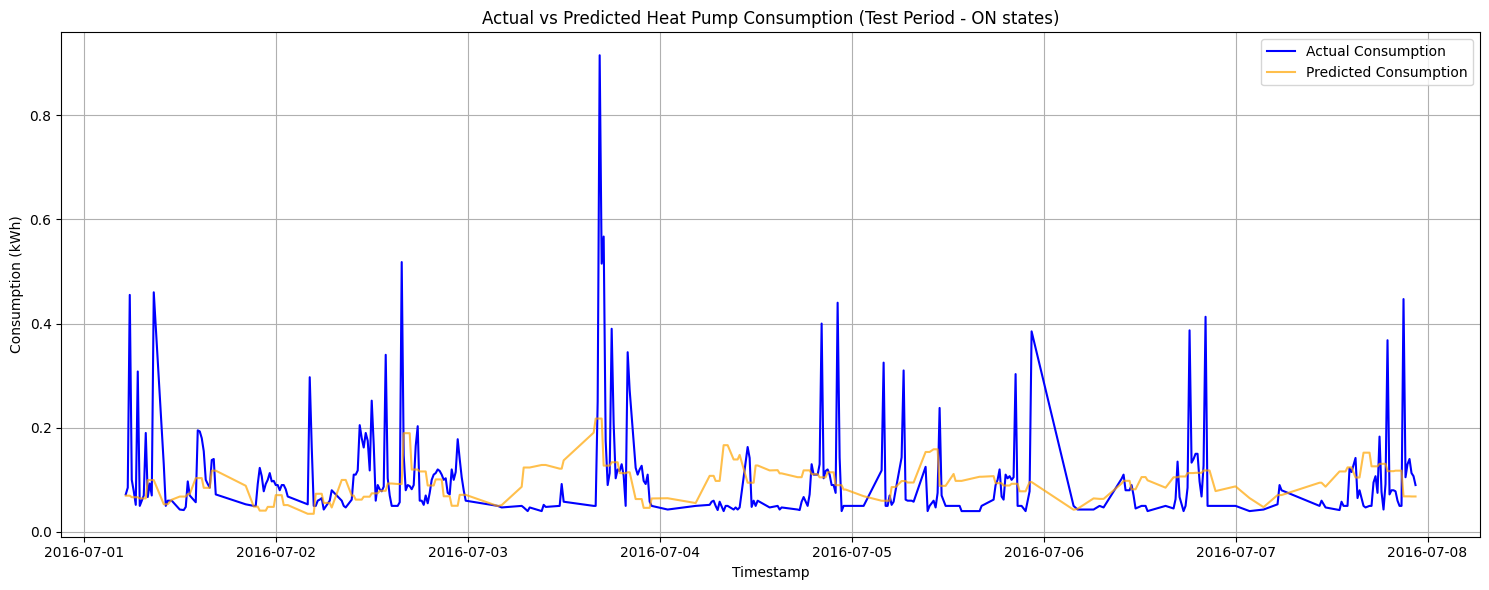

In [65]:
# Plot actual vs predicted

plt.figure(figsize=(15,6))
plt.plot(df_test_compare.index, df_test_compare['Actual Consumption'], label='Actual Consumption', color='blue')
plt.plot(df_test_compare.index, df_test_compare['Predicted Consumption'], label='Predicted Consumption', color='orange', alpha=0.7)
plt.title('Actual vs Predicted Heat Pump Consumption (Test Period - ON states)')
plt.xlabel('Timestamp')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

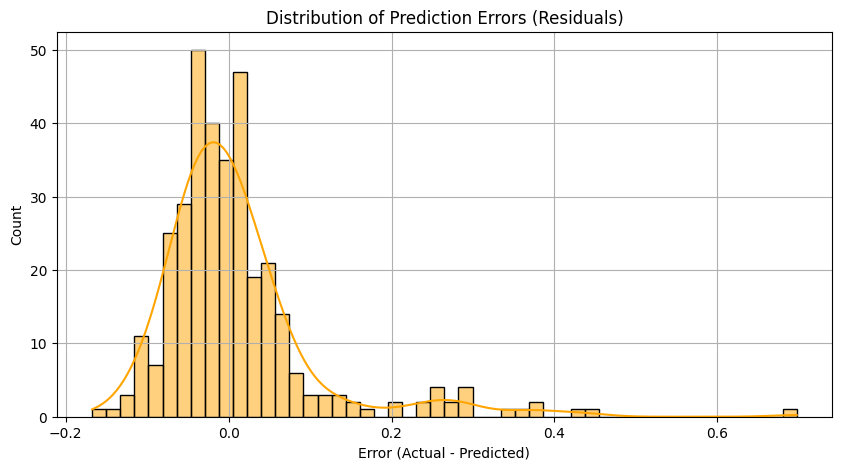

In [66]:
residuals = y_test_reg - y_test_pred
plt.figure(figsize=(10,5))
sns.histplot(residuals, bins=50, kde=True, color='orange')
plt.title('Distribution of Prediction Errors (Residuals)')
plt.xlabel('Error (Actual - Predicted)')
plt.grid(True)
plt.show()

In [67]:
print("Error summary:")
print(residuals.describe())

Error summary:
count    342.000000
mean       0.009651
std        0.098313
min       -0.167604
25%       -0.044106
50%       -0.009868
75%        0.032183
max        0.697396
Name: r5_gi, dtype: float64


In [68]:
# 1. Residuals statistics
residuals = y_test_reg - y_test_pred
print("Residuals summary:")
print(residuals.describe())

Residuals summary:
count    342.000000
mean       0.009651
std        0.098313
min       -0.167604
25%       -0.044106
50%       -0.009868
75%        0.032183
max        0.697396
Name: r5_gi, dtype: float64


In [69]:
# 2. Residuals correlation with actual values (to check bias)
corr = np.corrcoef(y_test_reg, residuals)[0,1]
print(f"\nCorrelation between actual and residuals: {corr:.4f}")


Correlation between actual and residuals: 0.9432


###
A correlation of +0.9432 between actual and residuals means:

As the actual consumption increases, the residuals (errors) also increase.

In other words: the model underestimates high values and overestimates low values.


In [70]:
# 3. Baseline model error comparison (naive: predict mean consumption from train set)
baseline_pred = np.full_like(y_test_reg, y_train_reg.mean())
baseline_rmse = np.sqrt(np.mean((y_test_reg - baseline_pred)**2))
model_rmse = np.sqrt(np.mean((y_test_reg - y_test_pred)**2))
print(f"\nBaseline RMSE: {baseline_rmse:.4f}")
print(f"Model RMSE: {model_rmse:.4f}")
print(f"RMSE improvement over baseline: {baseline_rmse - model_rmse:.4f}")


Baseline RMSE: 0.0970
Model RMSE: 0.0986
RMSE improvement over baseline: -0.0017


### Future prediction

In [71]:
# future prediction window

future_start = pd.Timestamp("2016-07-08 00:00:00+00:00")
future_end = pd.Timestamp("2016-07-30 23:45:00+00:00")

df_future = df.copy()
df_future = df_future.loc[future_start:future_end].copy()

In [72]:
# Feature generation

df_future['hour'] = df_future.index.hour
df_future['dayofweek'] = df_future.index.dayofweek
df_future['quarter'] = df_future.index.quarter
df_future['month'] = df_future.index.month
df_future['year'] = df_future.index.year
df_future['dayofyear'] = df_future.index.dayofyear
df_future['dayofmonth'] = df_future.index.day
df_future['weekofyear'] = df_future.index.isocalendar().week.astype(int)

In [73]:
# predict using trained model

X_future = df_future[feature_cols_reg]
df_future['Predicted_r5_gi'] = reg_model.predict(X_future)

In [74]:
print(df_future[['r5_gi', 'Predicted_r5_gi']].head())

                           r5_gi  Predicted_r5_gi
utc_timestamp                                    
2016-07-08 00:00:00+00:00   0.03         0.092431
2016-07-08 00:15:00+00:00   0.04         0.092431
2016-07-08 00:30:00+00:00   0.03         0.092431
2016-07-08 00:45:00+00:00   0.03         0.092431
2016-07-08 01:00:00+00:00   0.03         0.071102


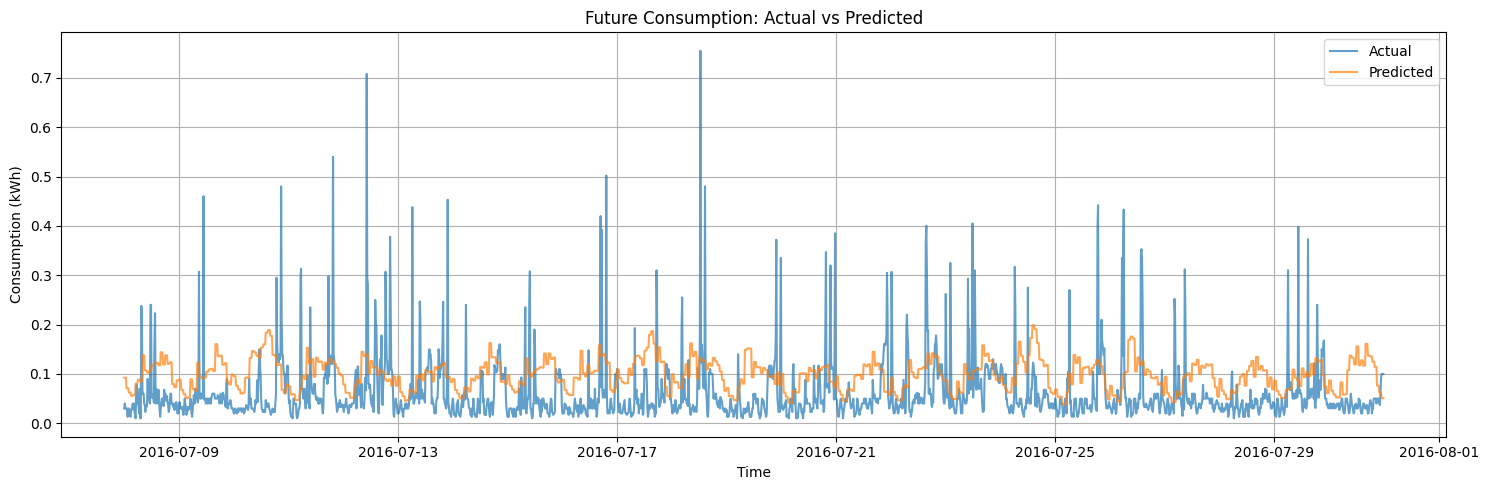

In [75]:
plt.figure(figsize=(15,5))
plt.plot(df_future.index, df_future['r5_gi'], label='Actual', alpha=0.7)
plt.plot(df_future.index, df_future['Predicted_r5_gi'], label='Predicted', alpha=0.7)
plt.title("Future Consumption: Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Consumption (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [76]:
df_future['Error'] = df_future['r5_gi'] - df_future['Predicted_r5_gi']
print(df_future['Error'].describe())

count    2208.000000
mean       -0.037136
std         0.068215
min        -0.162656
25%        -0.073068
50%        -0.046079
75%        -0.017421
max         0.622237
Name: Error, dtype: float64


In [77]:
within_margin = (df_future['Error'].abs() <= 0.1).sum()
total_points = len(df_future)
print(f"Predictions within ±0.1 kWh: {within_margin} out of {total_points} ({(within_margin / total_points * 100):.2f}%)")

Predictions within ±0.1 kWh: 1917 out of 2208 (86.82%)


### Concluding r5_gi vs r1_hp results:

1. r5_gi is much smoother, which means the model can learn patterns more easily without overfitting or missing sudden transitions.

2. r1_hp has highly imbalanced behavior — long OFF periods and sharp ON bursts. r5_gi appears to be more frequently ON, or at least has fewer sudden spikes.

3. r1_hp behaves like a binary appliance (heating kicks in → big jump), which leads to higher variance, more error, and more false spikes. r5_gi behaves like background consumption, easier for models like XGBoost to fit with basic features.

